
---

# **Projeto 04** | Pipeline de Dados do Telegram II
####Projeto Desenvolvido por[ André Pereira](https://www.linkedin.com/in/andrepeersil/), para o fechamento do curso Profissão Analista de Dados da EBAC.
---

## **0\. Contexto**

Este projeto visa o desenvolvimento de um **Pipeline de Dados**, com o objetivo de capturar, armazenar e transformar mensagens provenientes de um grupo no Telegram. O pipeline será responsável por ingerir os dados em intervalos de 24h, realizar o processamento e armazenamento em uma infraestrutura de dados otimizada para suportar consultas eficientes.

A pipeline será dividida em uma etapa de preparação e três etapas de transformação, conforme esquema da imagem abaixo.

**Arquitetura**

<img src="https://i.ibb.co/CzmH3mt/diagrama.jpg" alt="arquitetura">

##**1\. Preparação no Telegram**##

O grupo escolhido para a extração dos dados é o **grupo bot ebac** com participação de 2 usuários e o *bot* que fará a captação das mensagens.

A criação do bot foi realizada através da ferramenta BotFather, nativa do Telegram.
O *Bot* fornece um *Token* que permite a busca das mensagens via API.



*   Criação do bot no Telegram.



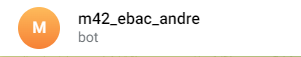


*   Criação do grupo no Telegram



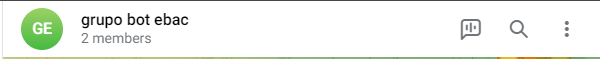


*   Bot como Admin no grupo



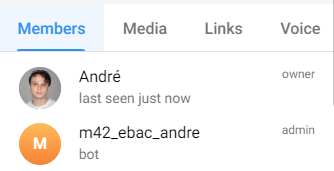


*  Bot desativado para ser inserido em novos grupos



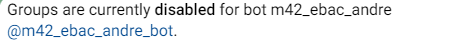


*   Mensagens trocadas dentro do grupo


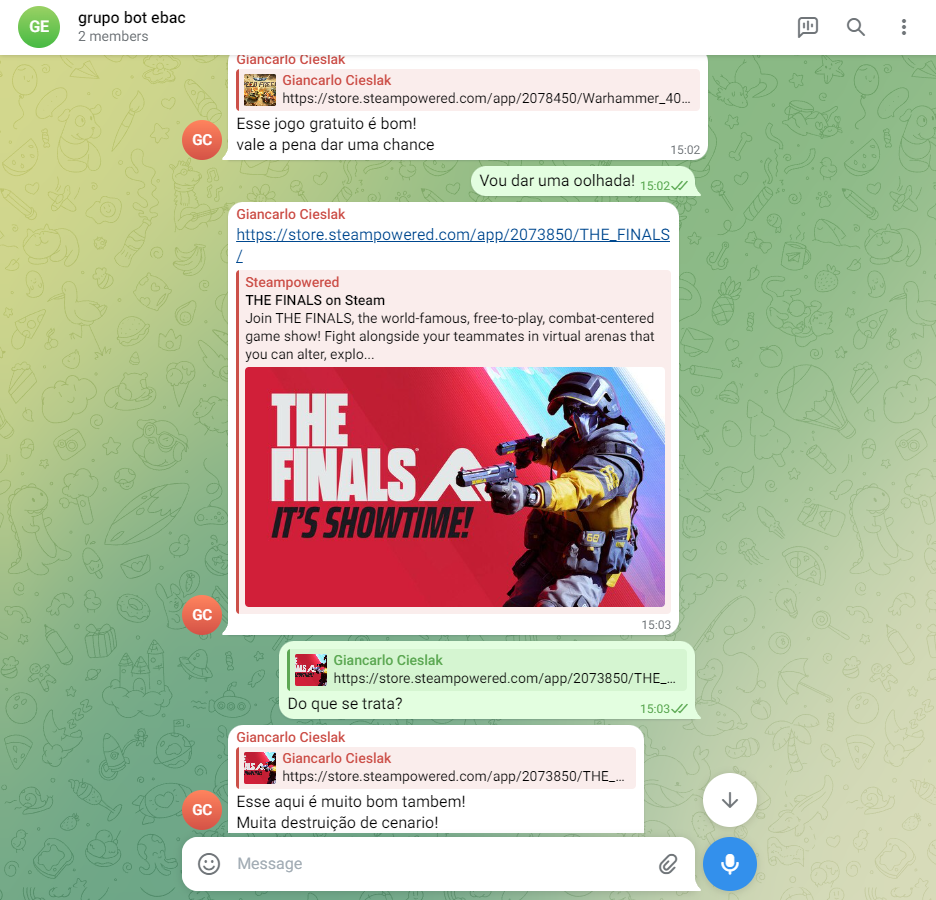

As mensagens são exportadas no formato JSON, com diversas informações de cada mensagem.

Exemplo de uma mensagem cedida pelo Telegram através de sua API.

```
{
      "update_id": 282092159,
      "message": {
        "message_id": 34,
        "from": {
          "id": 5677454704,
          "is_bot": false,
          "first_name": "Andr\u00e9",
          "language_code": "en"
        },
        "chat": {
          "id": -4586845308,
          "title": "grupo bot ebac",
          "type": "group",
          "all_members_are_administrators": true
        },
        "date": 1729636051,
        "text": "Olá Mundo"
      }
```



As mensagens precisam de um *TOKEN* para serem acessadas, tal *TOKEN* é gerado pelo `BotFather`

In [ ]:
from getpass import getpass

token = getpass()

··········


A `url` base é comum a todos os métodos da API. Consite do url + o TOKEN do bot.

In [ ]:
import json

base_url = f'https://api.telegram.org/bot{token}'

Com o método `getMe` vamos receber informações do bot.

```
# This is formatted as code
```



In [ ]:
import requests

response = requests.get(url=f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "id": 7746421418,
    "is_bot": true,
    "first_name": "m42_ebac_andre",
    "username": "m42_ebac_andre_bot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false,
    "can_connect_to_business": false,
    "has_main_web_app": false
  }
}


In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 282092228,
      "message": {
        "message_id": 103,
        "from": {
          "id": 5677454704,
          "is_bot": false,
          "first_name": "Andr\u00e9",
          "language_code": "en"
        },
        "chat": {
          "id": -4586845308,
          "title": "grupo bot ebac",
          "type": "group",
          "all_members_are_administrators": true
        },
        "date": 1729818882,
        "photo": [
          {
            "file_id": "AgACAgEAAxkBAANnZxrxApHD1_qJnxOLL2i_E8oxuxcAAhqsMRunjdlEw9oiQMSETL8BAAMCAANzAAM2BA",
            "file_unique_id": "AQADGqwxG6eN2UR4",
            "file_size": 1632,
            "width": 90,
            "height": 61
          },
          {
            "file_id": "AgACAgEAAxkBAANnZxrxApHD1_qJnxOLL2i_E8oxuxcAAhqsMRunjdlEw9oiQMSETL8BAAMCAANtAAM2BA",
            "file_unique_id": "AQADGqwxG6eN2URy",
            "file_size": 17229,
            "width": 320,
            "height": 

##**2\. Ingestão de Dados do Telegram**##



Vamos subdividir a Etapa de Ingestão de dados nas etapas abaixo.





 - Criação do *bucket* no `AWS S3`;
 - Criação de função no `AWS Lambda`;
 - Criação de API *web* no `AWS API Gateway`;
 - Configurar o *webhook* da API de *bots* do **Telegram**.


### **2.1. AWS S3**

Para o armazenamento dos dados iniciais, que chamaremos de dados raw, vamos criar um bucket no AWS S3.


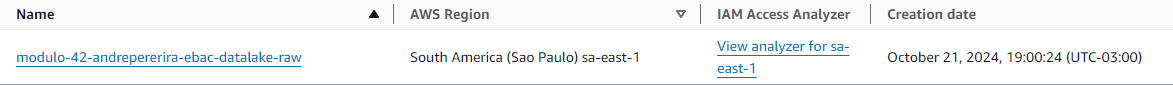

### **2.2. AWS Lambda**

Com o AWS Lambda vamos criar uma função que vai receber os dados do telegram, sendo cada mensagem um arquivo JSON, e salvar no bucket raw que criamos anteriormente.

Essa função realiza as seguintes ações:



1.   Estabelece um horário padrão `UTC-3`.
2.   Carrega o `JSON` do evento
3.   Verifica se o `ID` do grupo do Telegram está correto
4.   Cria um arquivo `JSON` com o nome da data da mensagem
5.   Salva no Bucket Raw










Código da função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")


*   Criação da função Lambda para captar dados do Telegram


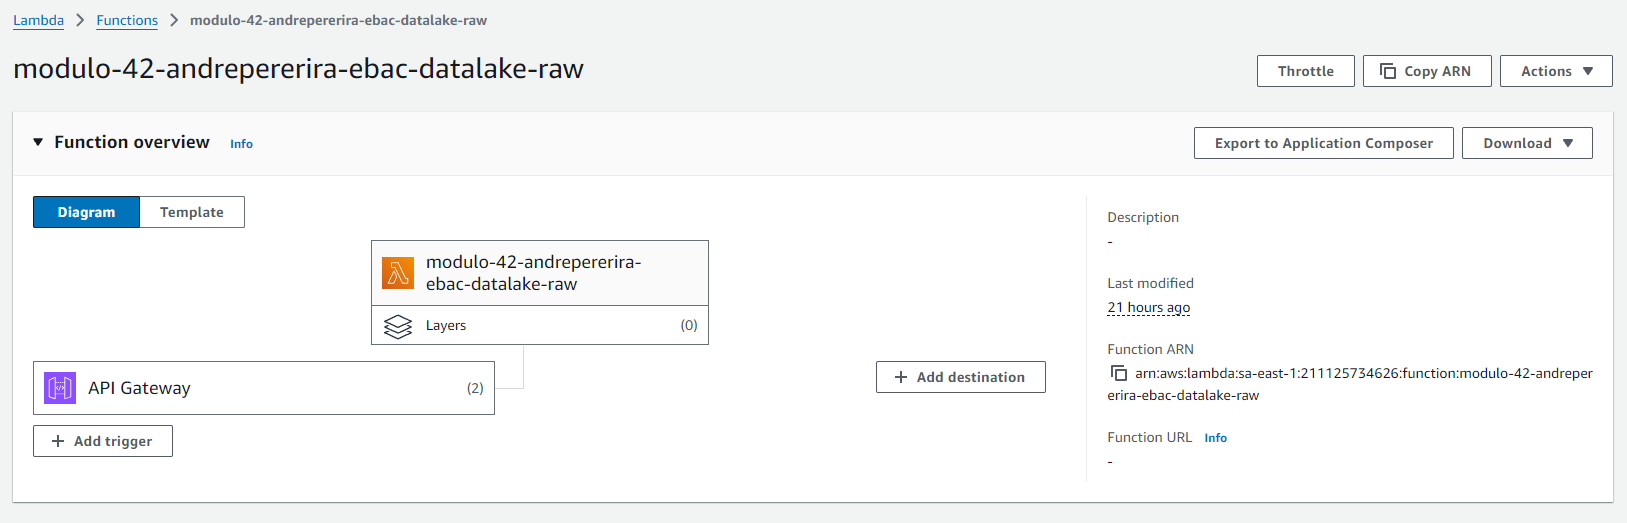

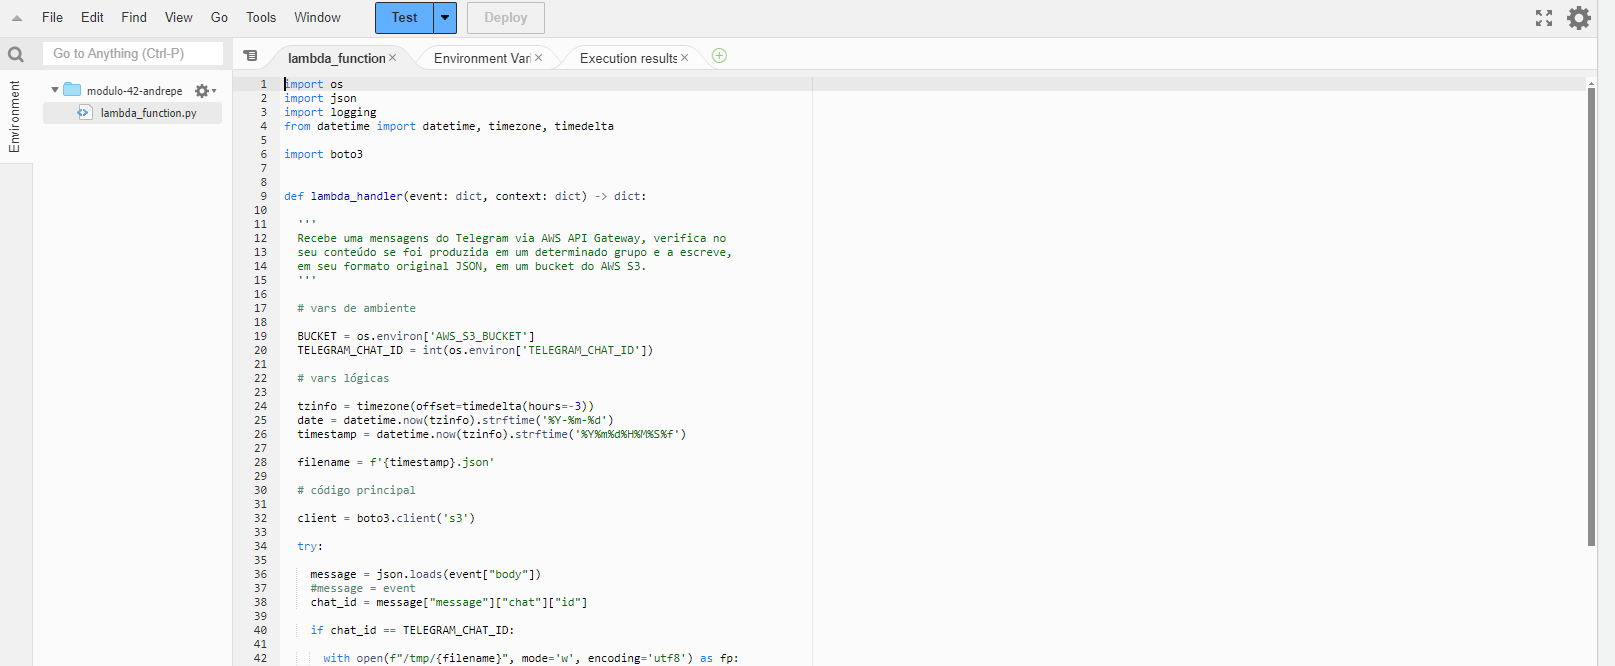

### **2.3. AWS API Gateway e configuração do Webhook**

Para a finalização da etapa de ingestão de dados, precisamos gerar a conexão entre a API do Telegram com nossa função que vai armazenar os dados no bucket S3.

Essa conexão é feita atráves da criação de uma API no AWS API Gateway e da configuração de um Webhook.




A API criada no AWS API Gateway gera um link, e com o Webhook conseguimos direcionar os dados para esse link.

Inserção do Link gerado pela API.

In [ ]:
from getpass import getpass

aws_api_gateway_url = getpass()

··········


Configuração do Webhook com o método `setWebhook` e o método `getWebhookInfo` para verificar se foi configurado corretamente.

In [ ]:
import requests
import json

response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://nvaizq2ted.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 63,
    "max_connections": 40,
    "ip_address": "52.67.147.89"
  }
}


*   Criação da API com AWS API Gateway

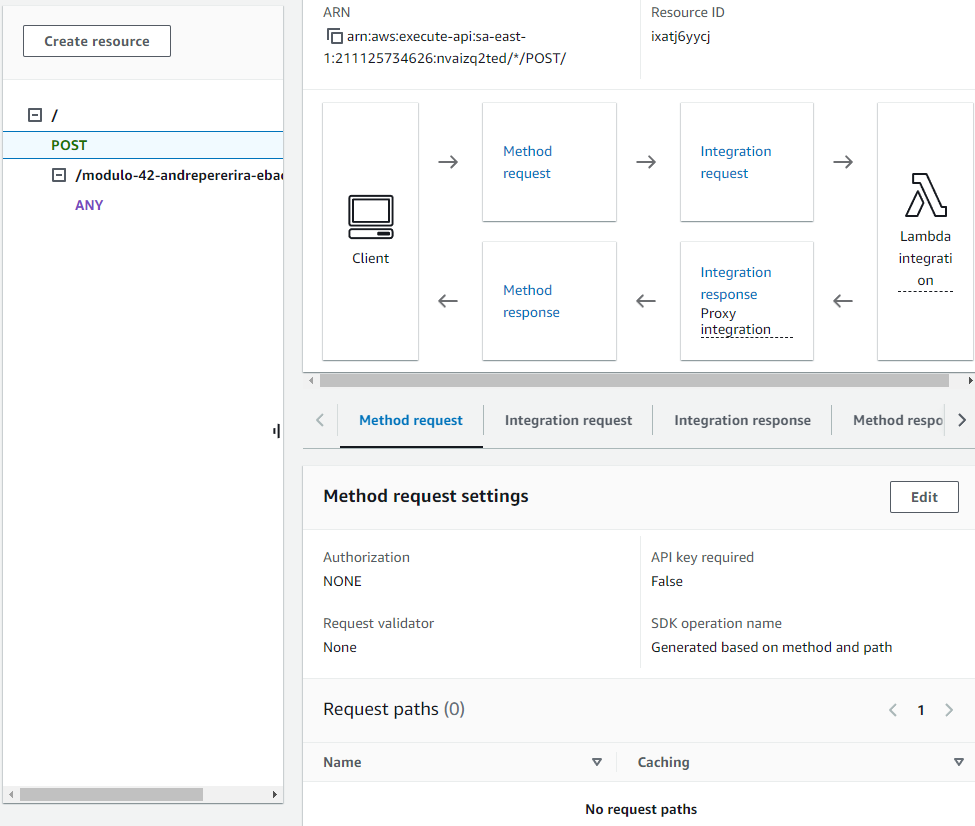

*   Dados captados do telegram armazenados no bucket raw, divididos em pastas pela data.

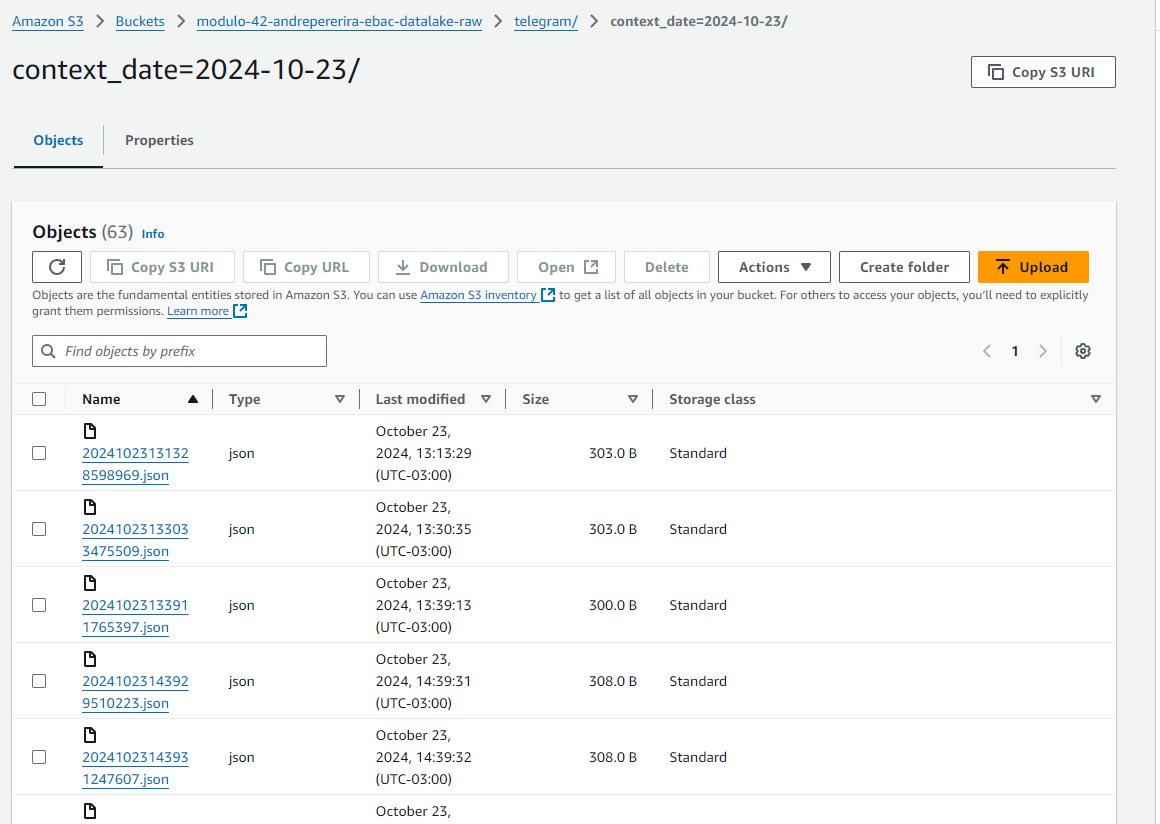

## **3\. Etapa 2: ETL**

A segunda etapa é a de `ETL(extract, transform, load)`, onde o dado Raw no formado `JSON` que está armazenado do `Bucket Raw` será transformado em um dado mais legível, no caso usaremos o formato `parquet`.


Essa etapa será subdividida nas etapas abaixo.

 - Criação de *schedule* no `AWS Event Bridge`;
 - Criação do *bucket enriched* no `AWS S3`;
 - Criação de função no `AWS Lambda`;





### **3.1. AWS EventBridge**

A extração dos dados, realizada na primeira etapa, foi automatizada através do `AWS Event Bridge`. A extração será realizada a cada 24h, sempre às 00:00.

*   Criação da automação com EventBridge

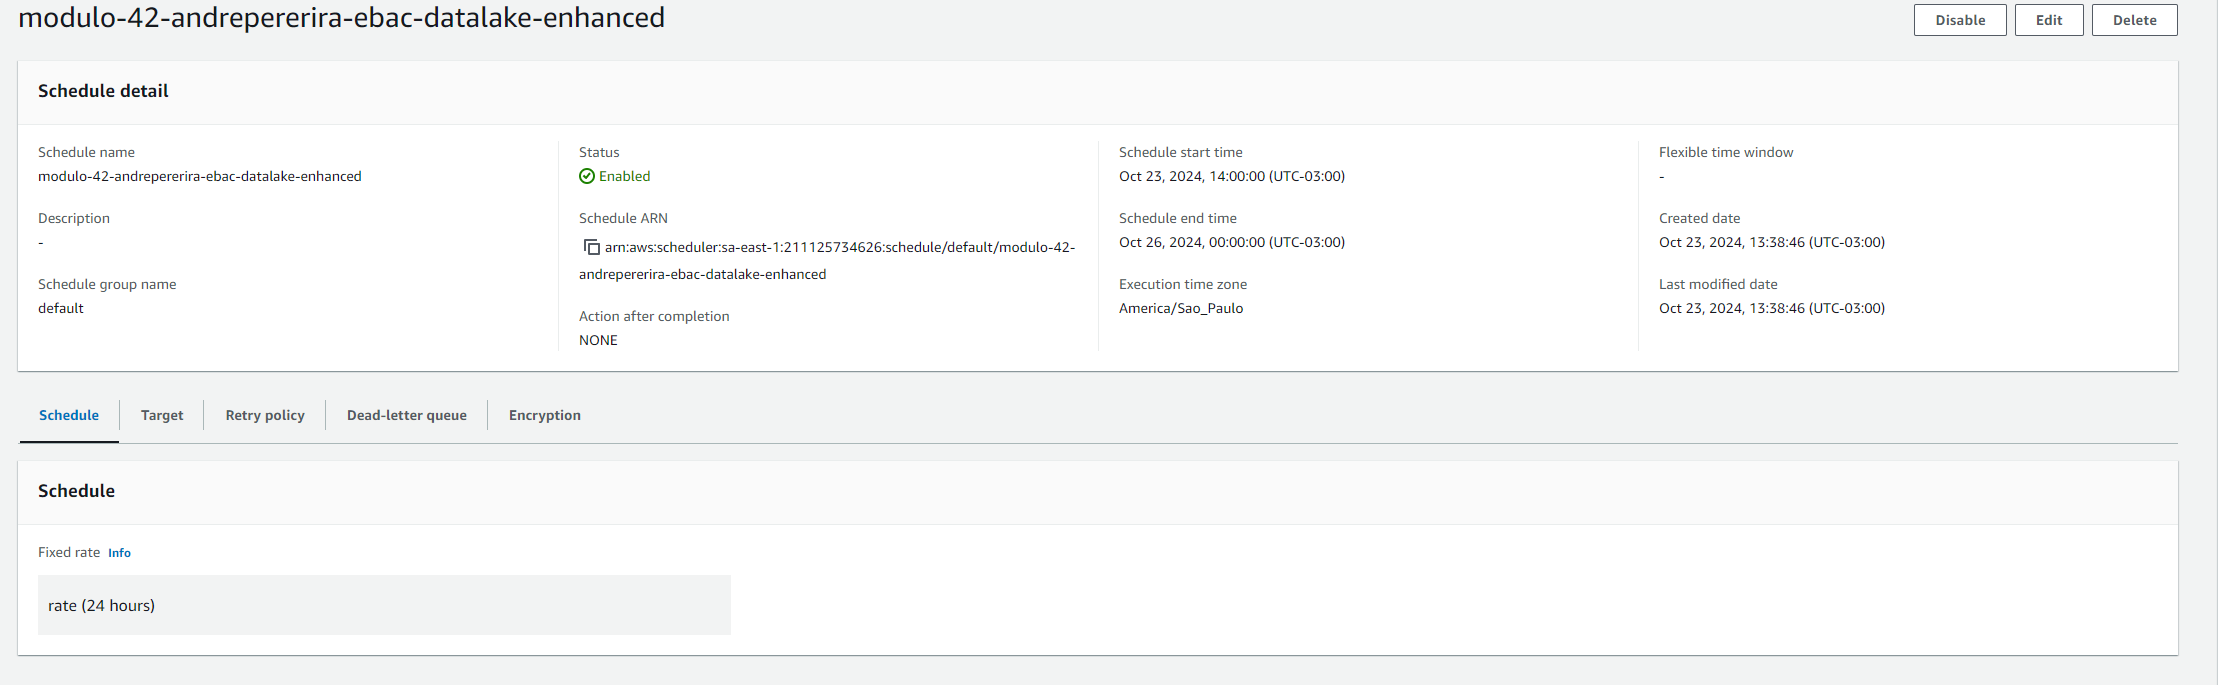

### **3.2. AWS S3**

Os dados raw e enriched devem estar em buckets separados, foi criado um novo bucket apra receber os dados já tratados.

*   Criação do *Bucket Enriched* na AWS S3


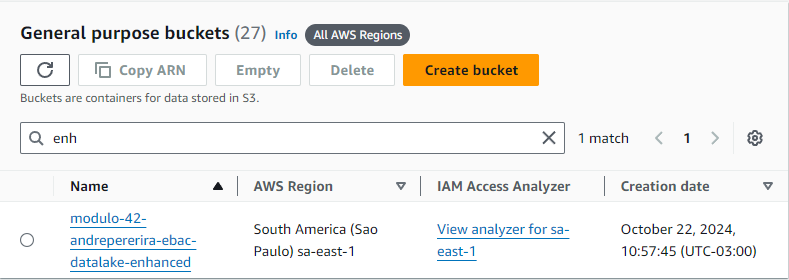

### **3.3. AWS Lambda**


A função que trata os dados raw realiza as seguintes ações:



1.   Define os buckets de dados brutos (RAW) e transformados (ENRICHED) no S3
2.   Ajusta a data para UTC-3, garantindo consistência temporal
3.   Filtra e processa os dados referentes ao dia anterior
4.   Baixa os arquivos JSON do bucket RAW para um diretório temporário local.
5.   Extrai informações específicas dos arquivos JSON e as converte em dicionários com a função `parse_data()`.
6.   Transforma os dicionários em tabelas PyArrow.
7.   Armazena a tabela no bucket ENRICHED em formato Parquet.
8.   Retorna True em caso de sucesso e False se ocorrer um erro.




In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

*   Criação da função que transforma os dados no formato *JSON* em dados no formato *Parquet*


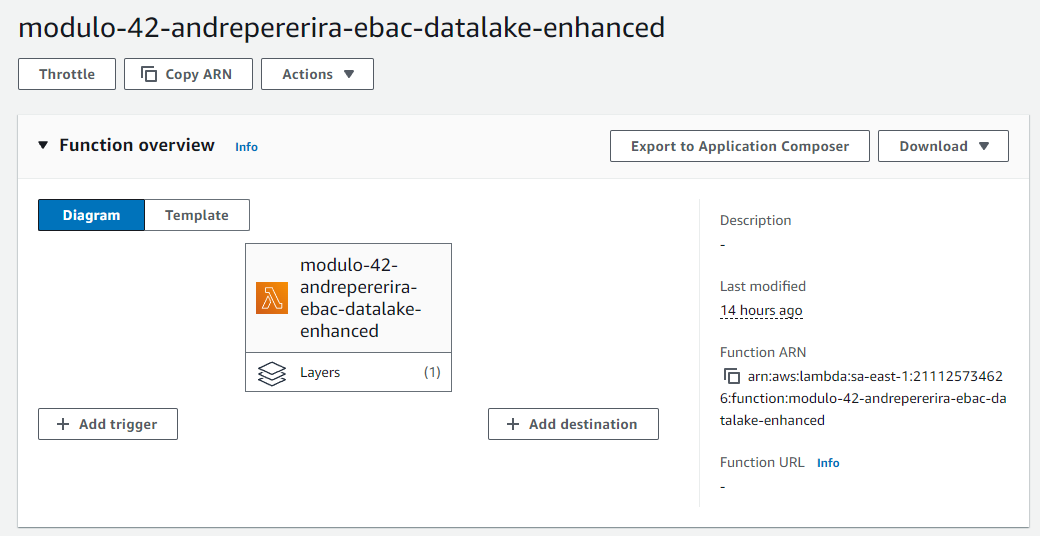

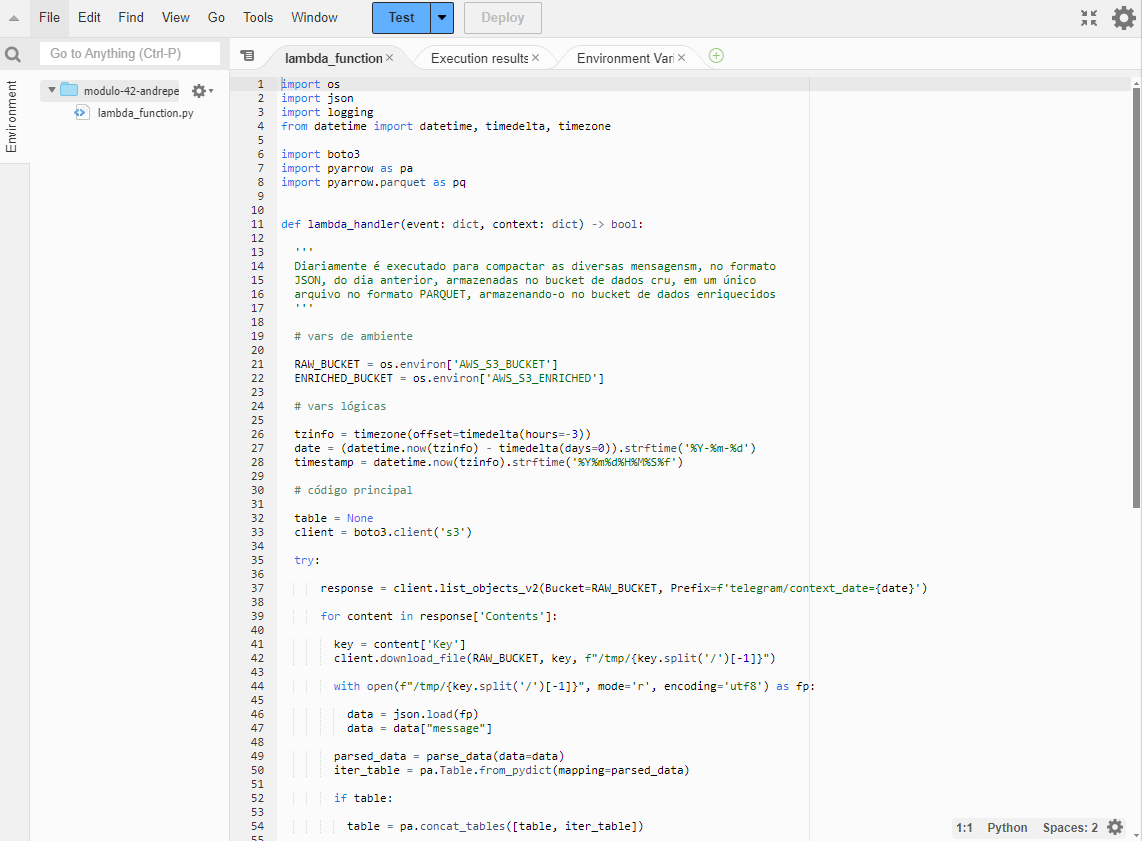

*   Dados já transformados no *bucket enriched* em formato Parquet

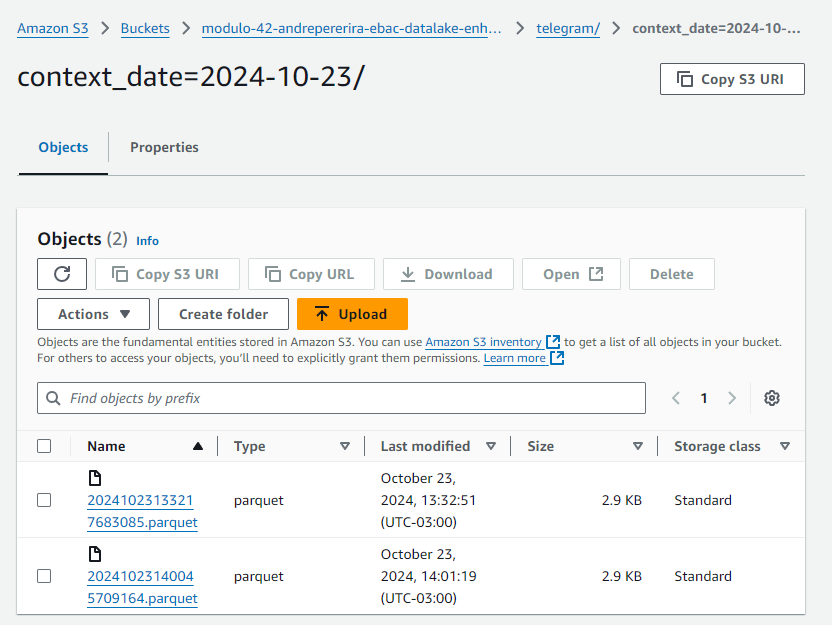

## **4\. Etapa 3: Apresentação**

Os dados já transformados, podemos criar uma tabela SQL para realizar as consultas.

Nessa tabela vamos ter as colunas sendo os dados extraídos anteriormente, que estão em formato parquet, sendo eles.

`mensage_id`: Id único referente a mensagem

`user_id`: Id referente ao usuário

`user_first_name`: String com o nome do usuário

`chat_id`: Id referente ao grupo do telegram

`chat_type`: Tipo da conversa, no caso um grupo

`text`: Texto da mensagem

`date`: Data que a mensagem foi enviada


```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'
```


A tabela foi particionada por datas.

```sql
MSCK REPAIR TABLE `telegram`;
```

Os 10 primeiros itens para consulta.

```sql
SELECT * FROM `telegram` LIMIT 10;
```

## **5\. Análises**

Com os dados em SQL podemos realizar consultas.

*  Verifica quais usuários mais mandaram mensagens




```sql
SELECT user_first_name,
count(*) as qtd
FROM "default"."telegram"
group by user_first_name
```



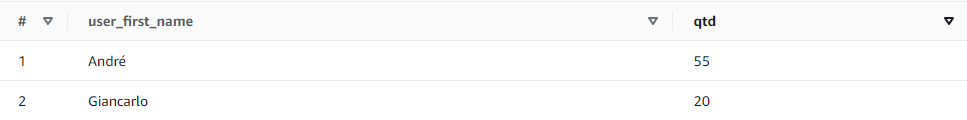

*  Média do tamanho de mensagens por usuários




```sql
SELECT user_first_name,
avg(length(text)) as media_mensagens
from "default"."telegram"
group by user_first_name
```



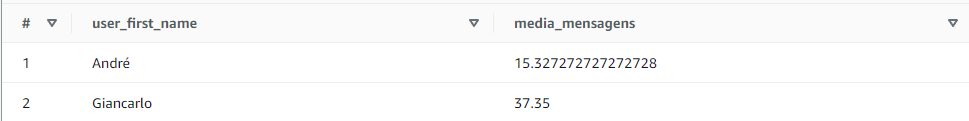

```sql
SELECT context_date,
avg(length(text)) as media_mensagens
from "default"."telegram"
group by context_date
```

*  Média do tamanho das mensagens por dia




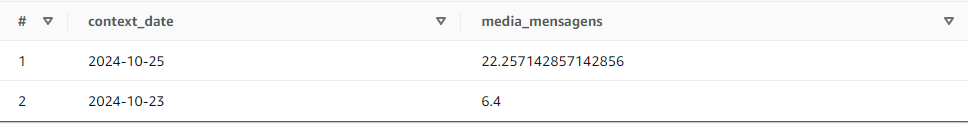

*  Cinco maiores mensagens

```sql
SELECT message_id, length(text) as tamanho_mensagem
from "default"."telegram"
order by length(text) desc
limit 5
```

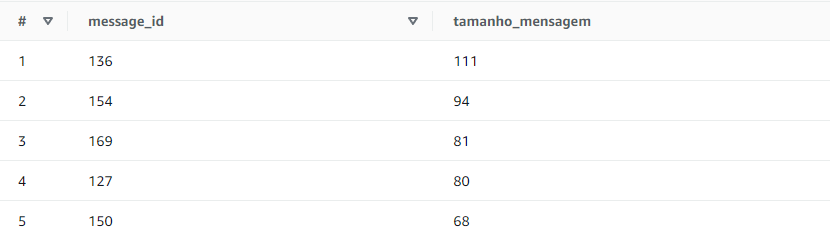

*  Quantas mensagens não foram de texto

```sql
SELECT count(*) as qtd_texto_vazio
from "default"."telegram"
where text = 'None'
group by text
```

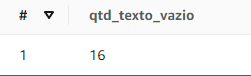

## **6\. Conclusão**


Neste projeto, desenvolvemos uma **pipeline de dados** completa, capaz de captar e transformar mensagens em um formato otimizado para consultas, facilitando a geração de insights para aprimoramentos contínuos.

O uso das ferramentas da AWS atendeu com excelência às necessidades do projeto, permitindo automação e escalabilidade eficientes.